In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import os
import re

import librosa
import soundfile as sf

import numpy as np
import matplotlib.pyplot as plt

from utils.config import load_config
from data.combined_audio_pair import CombinedAudioPair

In [6]:
config = load_config()
train_dir_path = config['data_paths']['train_raw_audio_path']
train_dir_path

'/app/data/raw/codecfake/train_flac'

In [9]:
file_ids = os.listdir(train_dir_path)
len(file_ids)

7513

In [19]:
def get_files(train_dir_path, file_id):
    dir_path = os.path.join(
        train_dir_path ,
        file_ids[0]
    )
    real_file = None
    fake_files = []
    for file_name in os.listdir(dir_path):
        # Fake file
        if bool(re.match(r'^F\d{2}', file_name)):
            fake_files.append(os.path.join(dir_path, file_name))
        else:
            real_file = os.path.join(dir_path, file_name)
    return real_file, fake_files

In [20]:
real_file, fake_files = get_files(train_dir_path, file_ids[0])
real_file, fake_files

('/app/data/raw/codecfake/train_flac/SSB01450236/SSB01450236.flac',
 ['/app/data/raw/codecfake/train_flac/SSB01450236/F04_SSB01450236.flac',
  '/app/data/raw/codecfake/train_flac/SSB01450236/F05_SSB01450236.flac',
  '/app/data/raw/codecfake/train_flac/SSB01450236/F01_SSB01450236.flac',
  '/app/data/raw/codecfake/train_flac/SSB01450236/F06_SSB01450236.flac',
  '/app/data/raw/codecfake/train_flac/SSB01450236/F02_SSB01450236.flac',
  '/app/data/raw/codecfake/train_flac/SSB01450236/F03_SSB01450236.flac'])

In [79]:
audio_pair = CombinedAudioPair(
    real_file_path=real_file,
    fake_file_paths=fake_files
)

In [80]:
audio_pair.get_info()

{'real': {'file_path': '/app/data/raw/codecfake/train_flac/SSB01450236/SSB01450236.flac',
  'label': 'real',
  'generation_method': 'Real Audio',
  'sample_rate': 44100,
  'duration': 7.148979591836735},
 'fake': [{'file_path': '/app/data/raw/codecfake/train_flac/SSB01450236/F04_SSB01450236.flac',
   'label': 'fake',
   'generation_method': 'EnCodec',
   'sample_rate': 24000,
   'duration': 7.16},
  {'file_path': '/app/data/raw/codecfake/train_flac/SSB01450236/F05_SSB01450236.flac',
   'label': 'fake',
   'generation_method': 'AudioDec',
   'sample_rate': 48000,
   'duration': 6.56875},
  {'file_path': '/app/data/raw/codecfake/train_flac/SSB01450236/F01_SSB01450236.flac',
   'label': 'fake',
   'generation_method': 'SoundStream',
   'sample_rate': 16000,
   'duration': 6.474125},
  {'file_path': '/app/data/raw/codecfake/train_flac/SSB01450236/F06_SSB01450236.flac',
   'label': 'fake',
   'generation_method': 'AcademicCodec',
   'sample_rate': 24000,
   'duration': 7.1466666666666665},


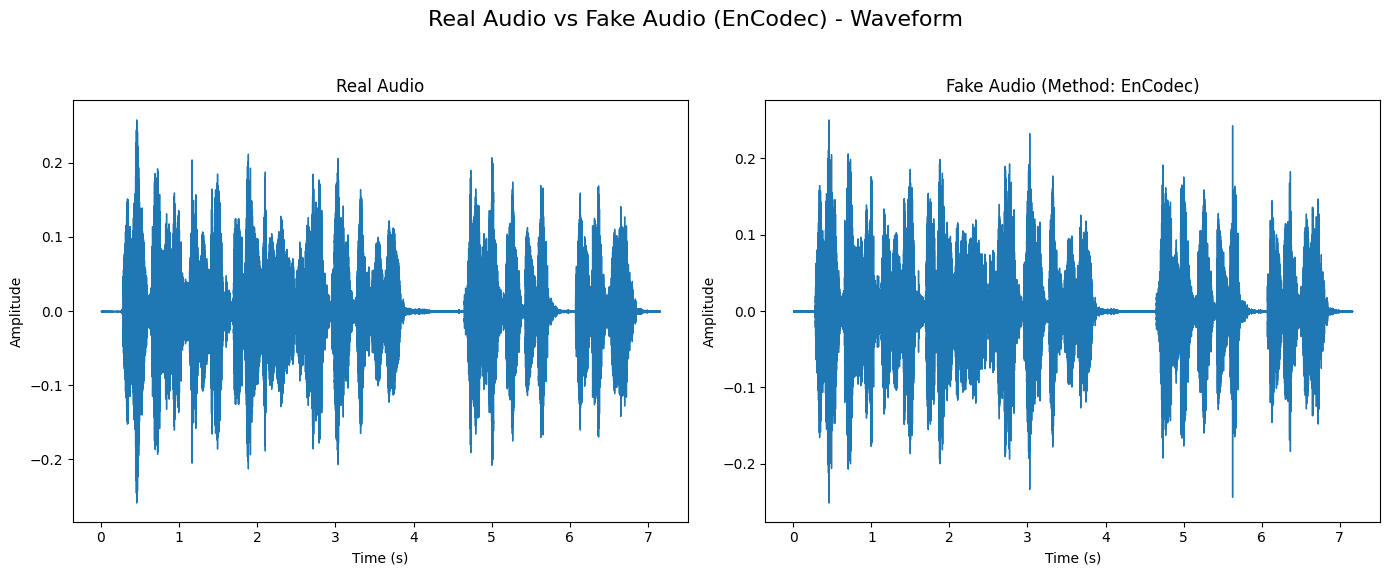

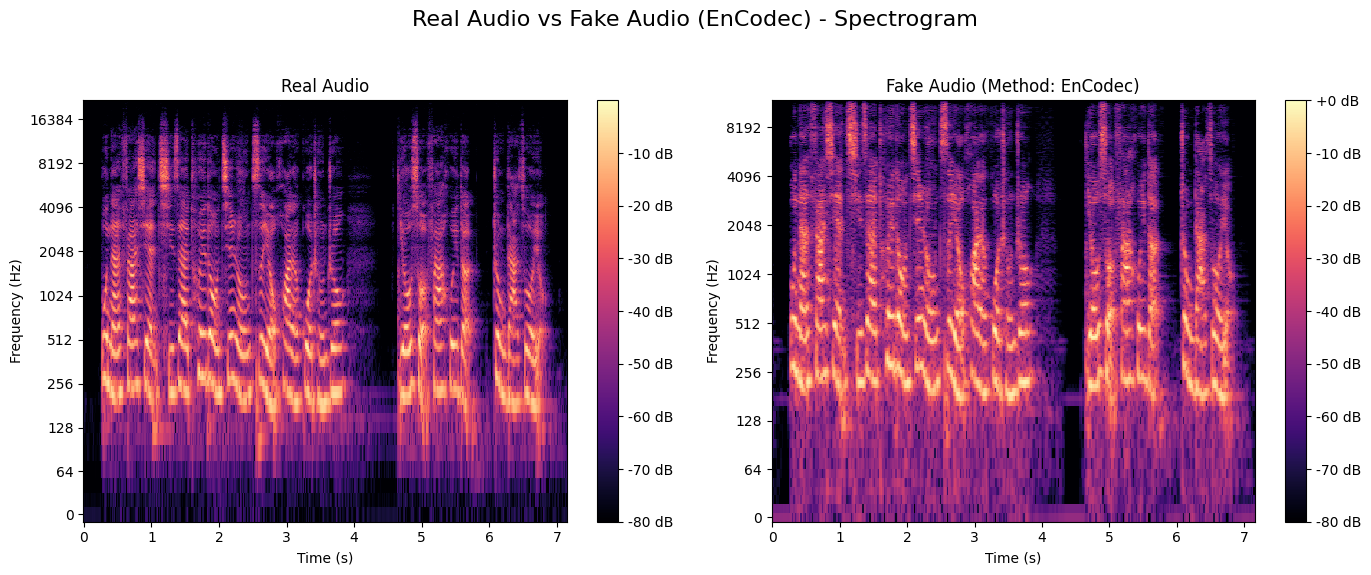

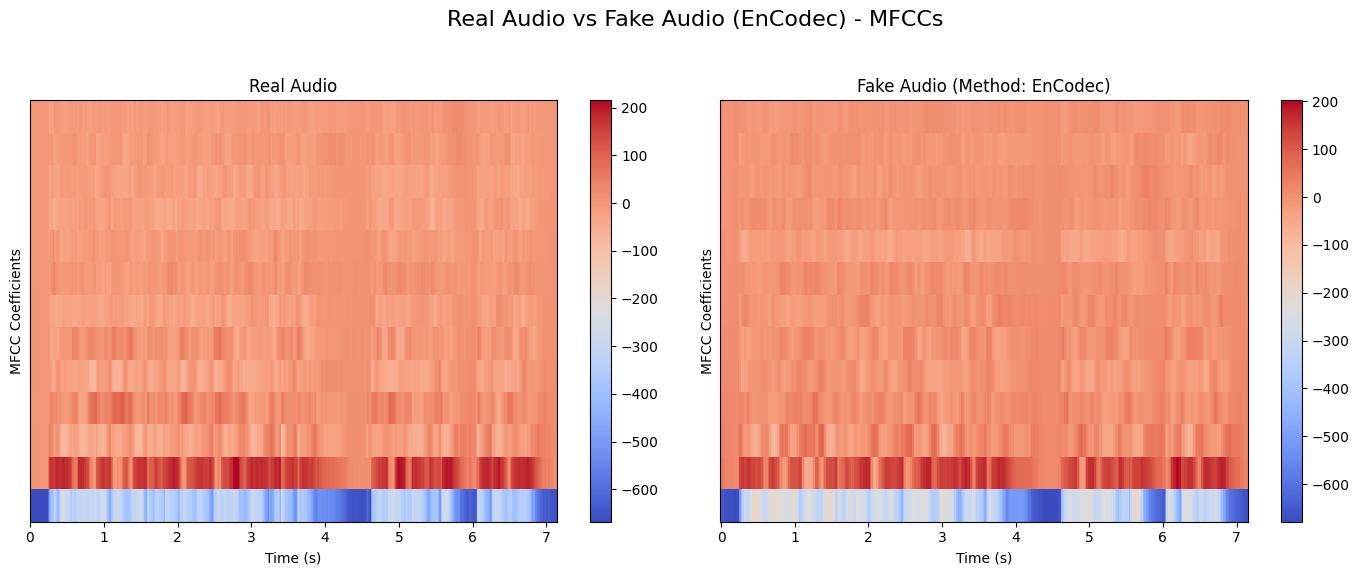

In [89]:
audio_pair.plot_real_vs_fake(fake_index=0)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from utils.config import load_config

In [7]:
config = load_config()
# train_dir_path = config['data_paths']['train_raw_path']
train_dir_path = config['data_paths']['train_flac_raw_path'] 
train_dir_path

'/app/data/raw/codecfake/train_flac'

## Extract Few Features

- **MFCCs**: Mel-frequency cepstral coefficients, a representation of the short-term power spectrum of sound.
- **Chroma**: Pertains to the 12 different pitch classes.
- **Mel Spectrogram**: A Mel-scaled power spectrogram.
- **Spectral Contrast**: Considers the spectral peak, valley, and their difference in each frequency sub-band.
- **Zero-Crossing Rate**: The rate at which the signal changes signs.

In [9]:
def extract_and_plot_features(real_path, fake_number):
    """Load real and fake audio files, extract features, and plot them side by side."""
    # Load the real audio file
    y_real, sr_real = librosa.load(real_path)
    
    # Generate fake file path based on fake_number
    fake_path = os.path.join(os.path.dirname(real_path),
                             f'F{str(fake_number).zfill(2)}_{os.path.basename(real_path)}')
    y_fake, sr_fake = librosa.load(fake_path)
    print(sr_real, sr_fake)
    # Extract features for both real and fake
    features = {}
    for label, y, sr in [('real', y_real, sr_real), ('fake', y_fake, sr_fake)]:
        features[label] = {
            'mfccs': librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),
            'chroma': librosa.feature.chroma_stft(y=y, sr=sr),
            'mel': librosa.feature.melspectrogram(y=y, sr=sr),
            'contrast': librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y)), sr=sr),
            'zero_cross': librosa.feature.zero_crossing_rate(y=y)
        }

    # Plotting
    fig, ax = plt.subplots(5, 2, figsize=(15, 20))

    titles = ['MFCC', 'Chroma', 'Mel-Spectrogram', 'Spectral Contrast', 'Zero Crossing Rate']
    for i, feature in enumerate(['mfccs', 'chroma', 'mel', 'contrast', 'zero_cross']):
        for j, label in enumerate(['real', 'fake']):
            data = features[label][feature]
            if feature != 'zero_cross':
                img = librosa.display.specshow(librosa.power_to_db(data, ref=np.max),
                                               x_axis='time', y_axis='mel', ax=ax[i, j])
                fig.colorbar(img, ax=ax[i, j], format="%+2.0f dB")
            else:
                ax[i, j].plot(data.T, label=f'{label} Zero Crossing Rate')
                ax[i, j].legend(loc="upper right")
            ax[i, j].set_title(f'{titles[i]} ({label})')
    
    plt.tight_layout()
    plt.show()

22050 22050


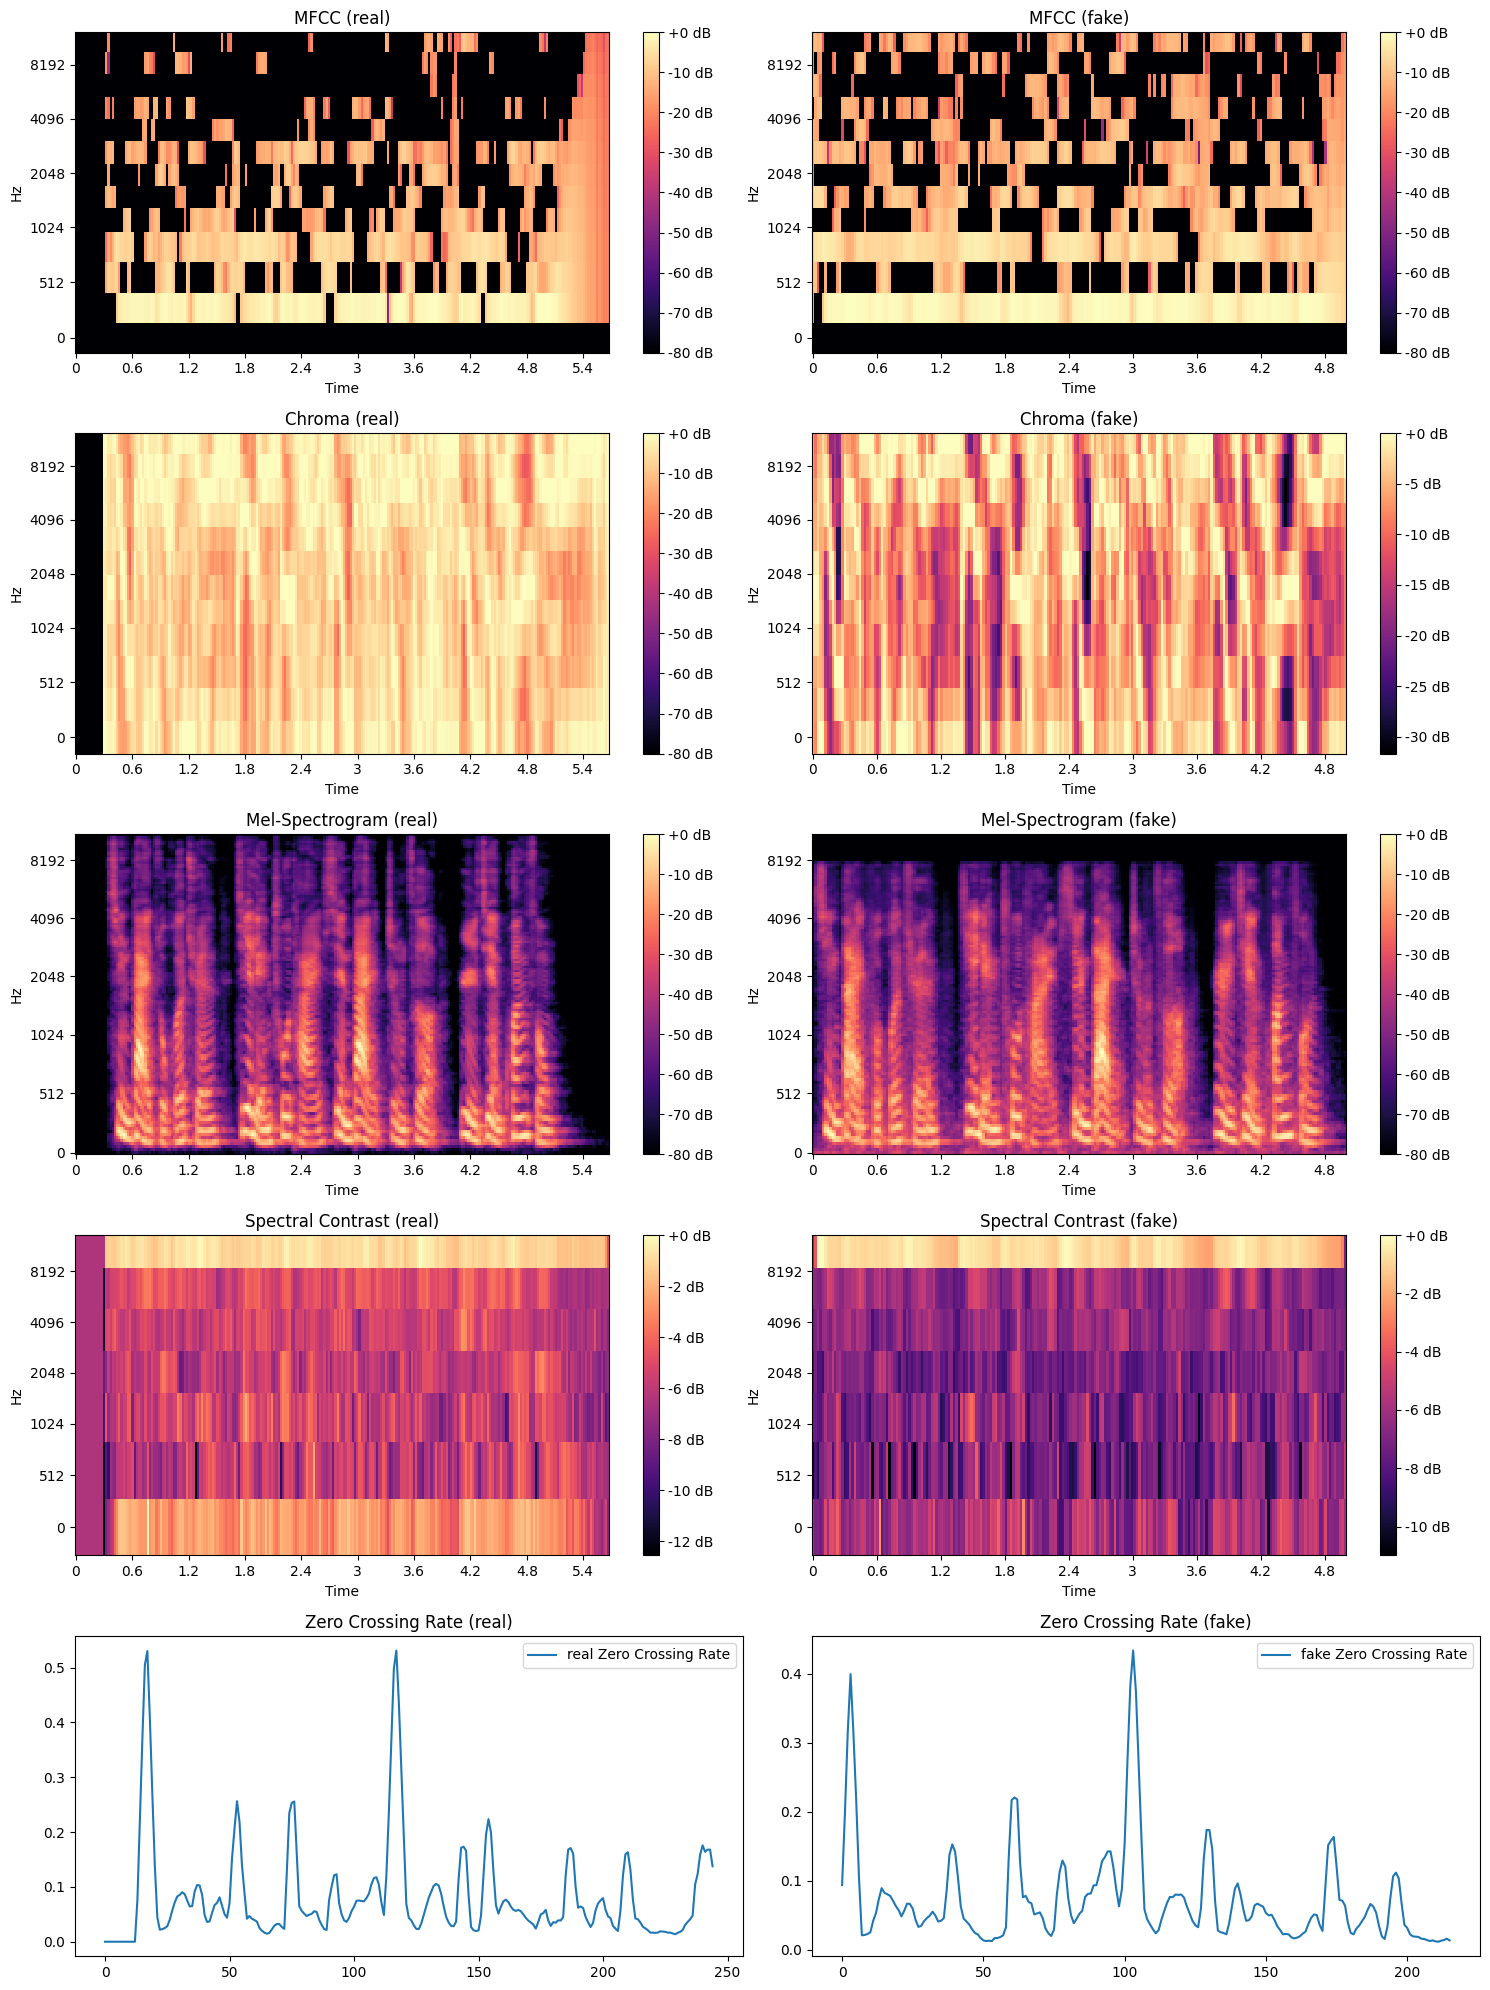

In [13]:
audio_file = os.path.join(train_dir_path, 'SSB13280206.wav')
extract_and_plot_features(audio_file, fake_number=1)

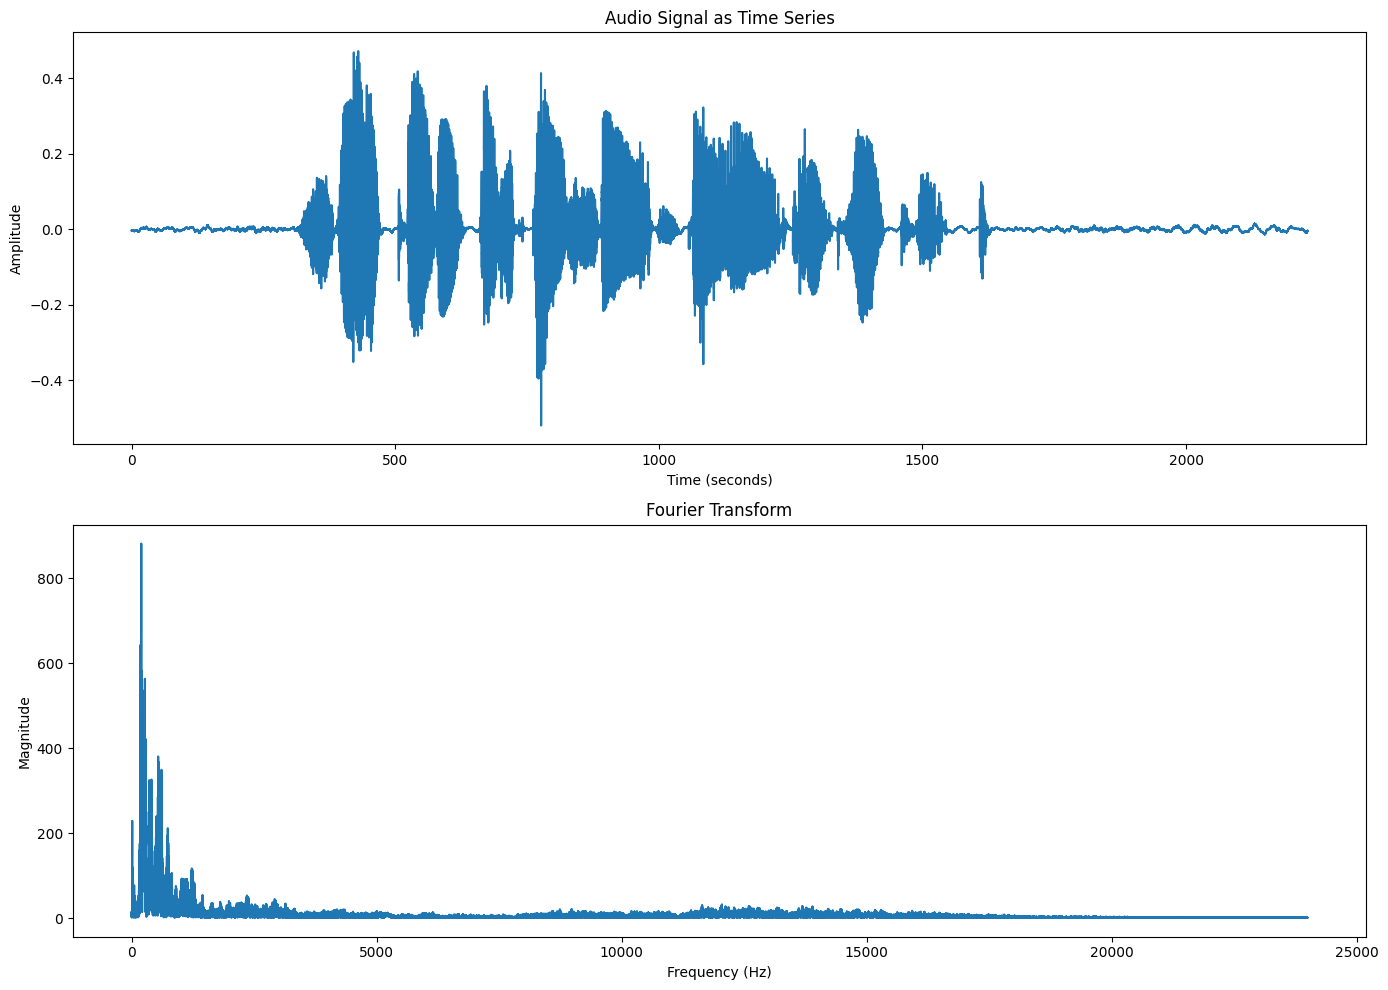

In [25]:
def plot_audio_signal(file_path):
    # Load the FLAC file using LibROSA
    audio, sample_rate = librosa.load(file_path, sr=None)

    # Create a time axis in seconds
    time = librosa.times_like(audio, sr=sample_rate)

    # Compute the Fourier Transform
    fft = np.fft.fft(audio)
    fft_freq = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Take only the positive part of the spectrum
    fft_magnitude = np.abs(fft)[:len(fft)//2]
    fft_freq = fft_freq[:len(fft)//2]

    # Plot the audio signal and its Fourier Transform
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Time domain plot
    ax1.plot(time, audio)
    ax1.set_title('Audio Signal as Time Series')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Amplitude')

    # Frequency domain plot
    ax2.plot(fft_freq, fft_magnitude)
    ax2.set_title('Fourier Transform')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')

    plt.tight_layout()
    plt.show()

file_path = os.path.join(train_dir_path, 'p238_025.flac')
plot_audio_signal(file_path)

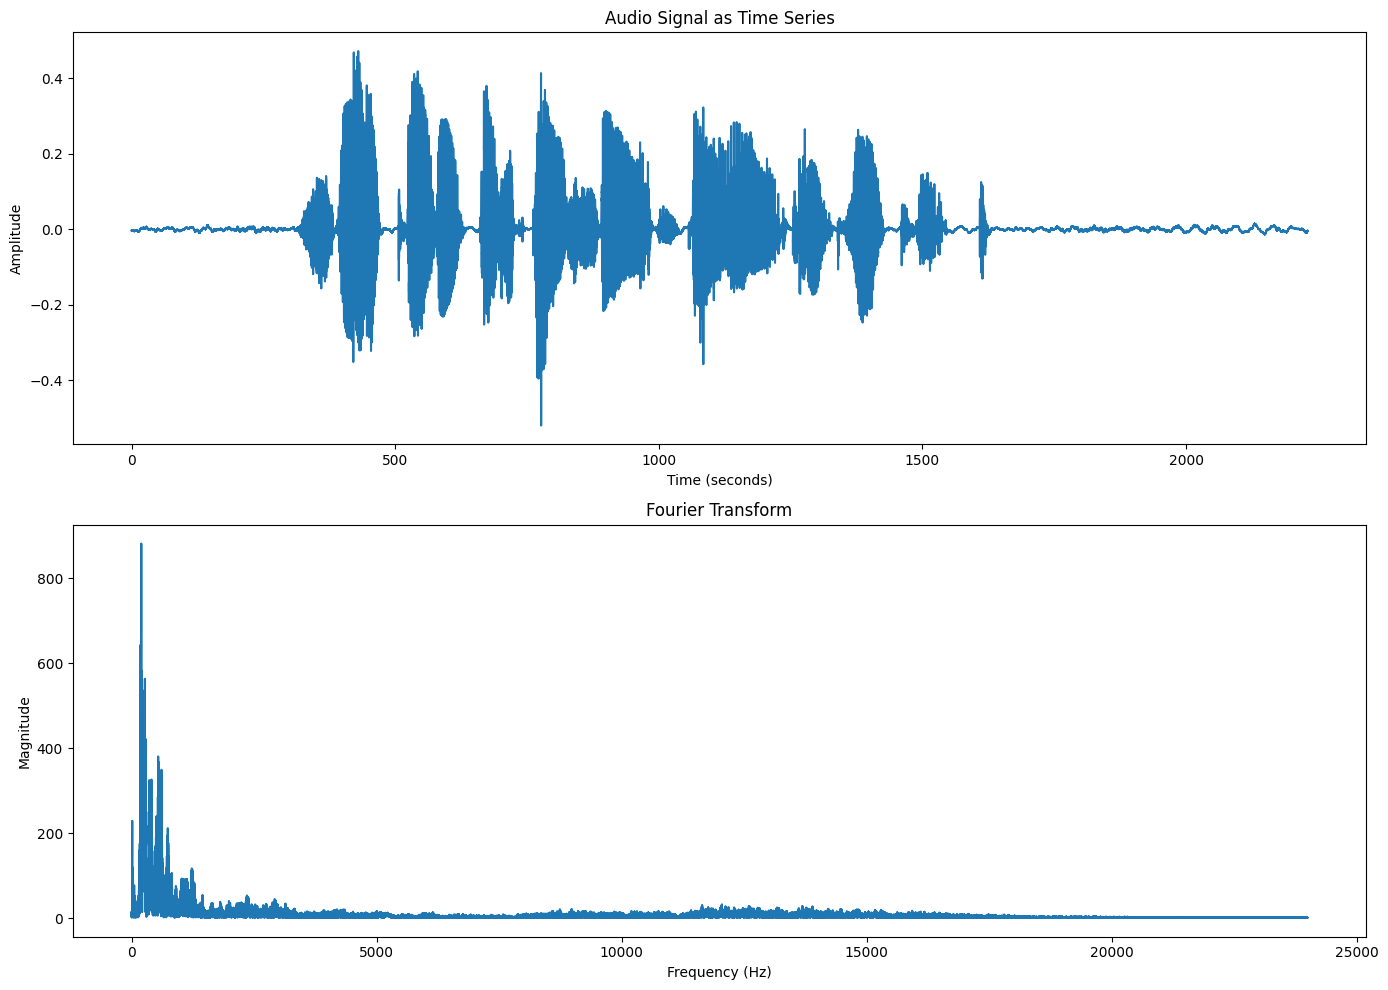

In [24]:
file_path = os.path.join(train_dir_path, 'F04_p238_025.flac')
plot_audio_signal(file_path)

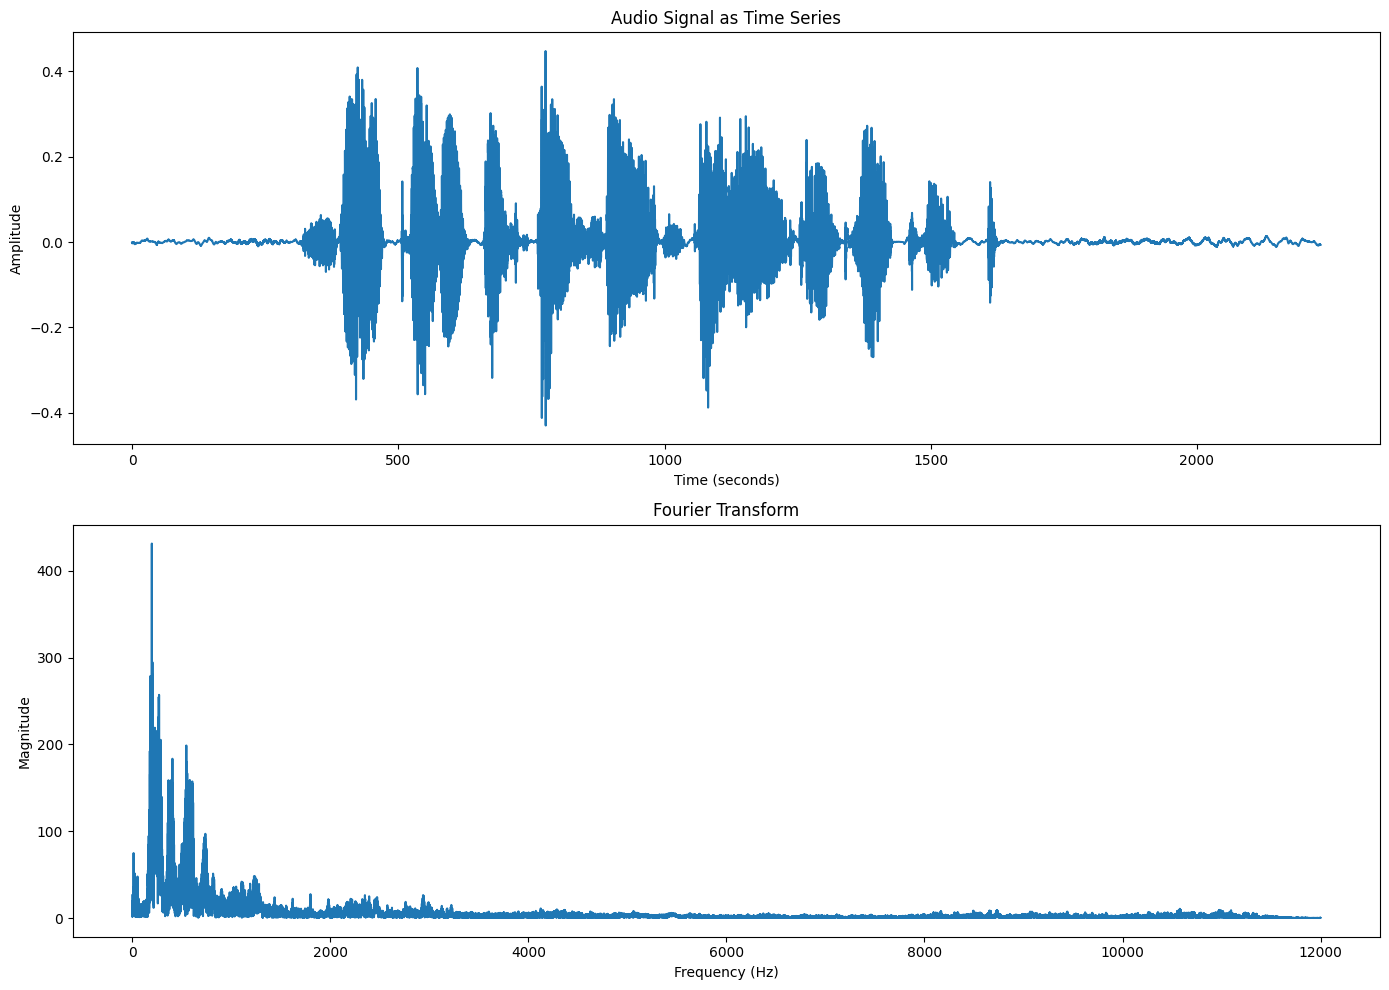

In [27]:
file_path = os.path.join(train_dir_path, 'F04_p238_025.flac')
plot_audio_signal(file_path)

In [5]:
for file in audio_files:
    if file.startswith('F0') and file[4:] in audio_files:
        print(file)

F02_SSB03790318.flac
F04_SSB05390455.flac
F01_p343_357.flac
F04_p300_362.flac
F04_SSB00430042.flac
F01_SSB04820323.flac
F06_SSB07780413.flac
F06_p256_072.flac
F05_SSB19020236.flac
F06_p283_359.flac
F03_SSB00380457.flac
F03_SSB05880179.flac
F06_SSB17280117.flac
F01_SSB11350443.flac
F04_p238_025.flac
F01_SSB03150262.flac
F03_SSB07780024.flac
F02_SSB04700065.flac
F02_p268_073.flac
F04_p258_073.flac
F06_SSB18910089.flac
F05_SSB01450250.flac
F02_SSB03790231.flac
F06_SSB03820150.flac
F02_SSB07860248.flac
F03_SSB13200039.flac
F01_p264_219.flac
F05_SSB11260420.flac
F06_p301_151.flac
F01_p308_006.flac
F01_SSB16840233.flac
F05_p313_153.flac
F02_SSB16250099.flac
F02_SSB17810220.flac
F04_SSB06930093.flac
F04_SSB16990239.flac
F06_p323_214.flac
F03_p341_395.flac
F06_p340_322.flac
F06_SSB12190236.flac
F02_p261_155.flac
F01_p257_106.flac
F01_SSB08220468.flac
F01_SSB01120458.flac
F02_SSB16990334.flac
F05_SSB00430042.flac
F04_SSB07620027.flac
F06_SSB02610142.flac
F01_p297_183.flac
F02_SSB12190236.flac
F

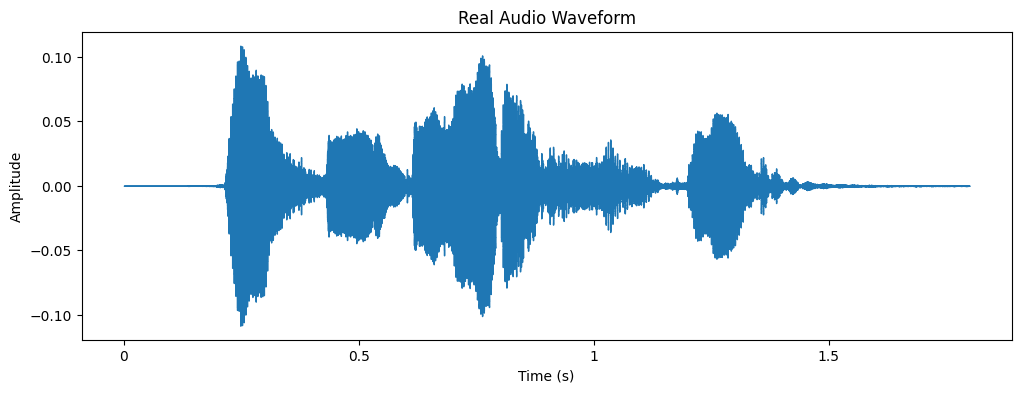

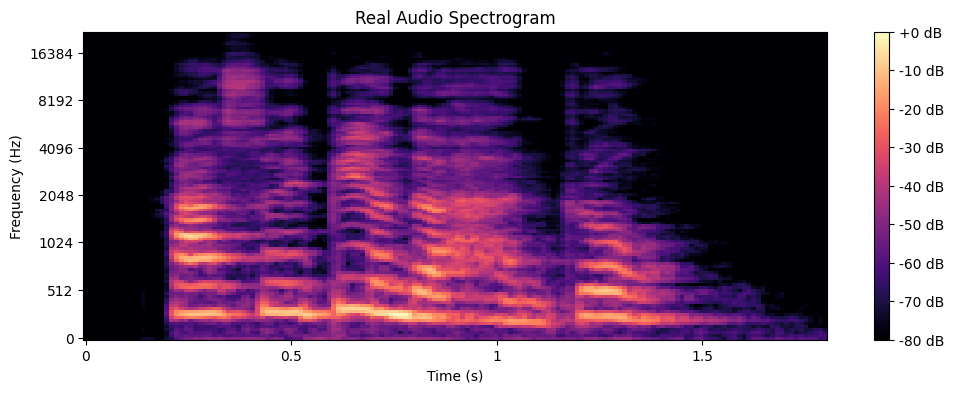

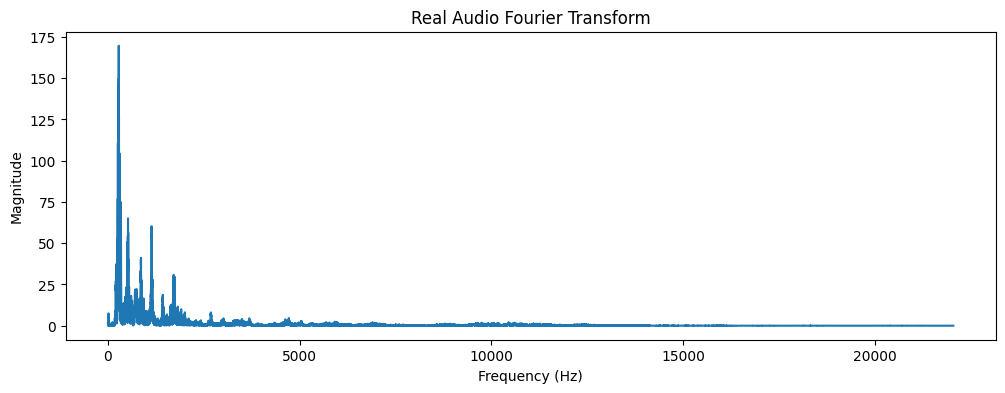

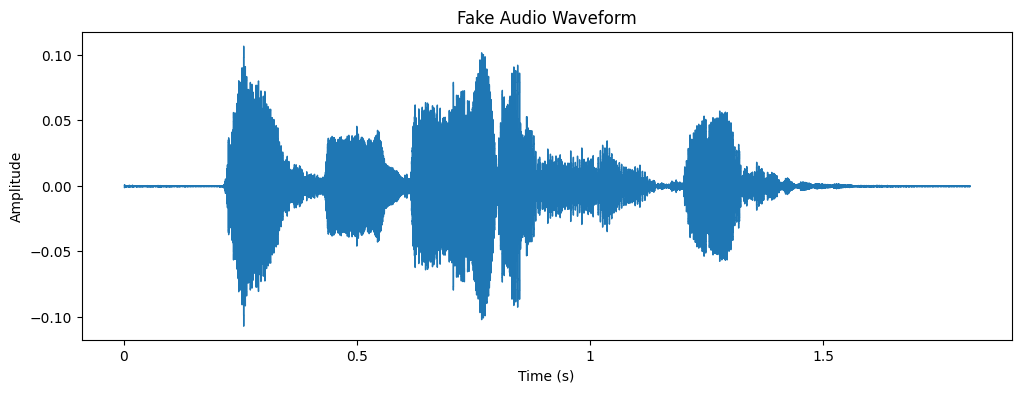

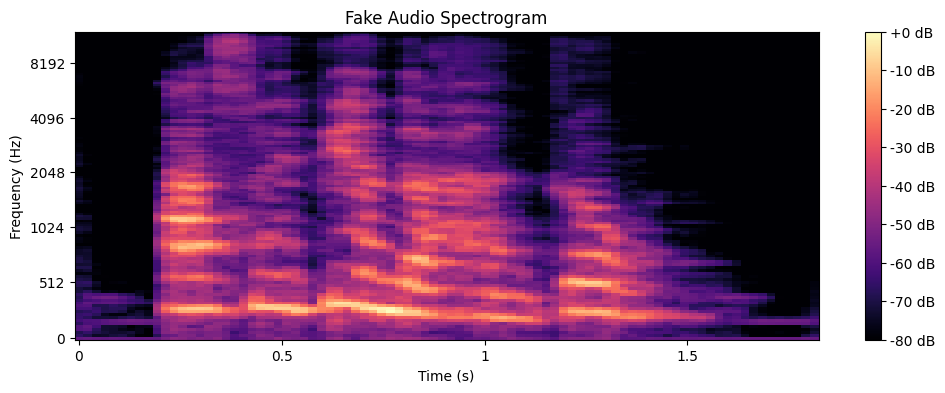

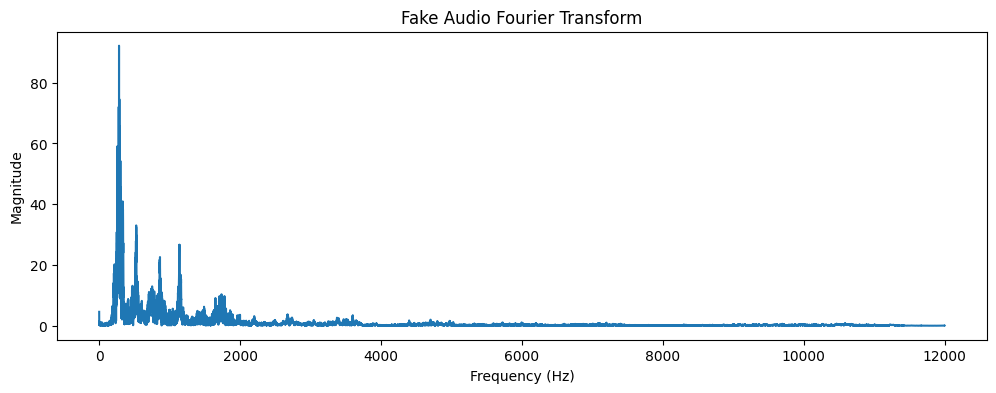

In [9]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def plot_waveform(audio, sr, title):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def plot_spectrogram(audio, sr, title):
    plt.figure(figsize=(12, 4))
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

def plot_fourier_transform(audio, sr, title):
    fft = np.fft.fft(audio)
    fft_freq = np.fft.fftfreq(len(fft), 1/sr)
    fft_magnitude = np.abs(fft)[:len(fft)//2]
    fft_freq = fft_freq[:len(fft)//2]
    
    plt.figure(figsize=(12, 4))
    plt.plot(fft_freq, fft_magnitude)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()


real_audio_file = os.path.join(train_dir_path, 'SSB00430042.flac')
fake_audio_file = os.path.join(train_dir_path, 'F04_SSB00430042.flac')

# Load and plot real audio
real_audio, real_sr = load_audio(real_audio_file)
plot_waveform(real_audio, real_sr, 'Real Audio Waveform')
plot_spectrogram(real_audio, real_sr, 'Real Audio Spectrogram')
plot_fourier_transform(real_audio, real_sr, 'Real Audio Fourier Transform')

# Load and plot fake audio
fake_audio, fake_sr = load_audio(fake_audio_file)
plot_waveform(fake_audio, fake_sr, 'Fake Audio Waveform')
plot_spectrogram(fake_audio, fake_sr, 'Fake Audio Spectrogram')
plot_fourier_transform(fake_audio, fake_sr, 'Fake Audio Fourier Transform')
